In [5]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.3 kB ? eta -:--:--
     -------------------------------------- 162.3/162.3 kB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -- ------------------------------------- 0.4/7.6 MB 11.8 MB/s eta 0:00:01
   ---- ----------------------------------- 0.8/7.6 MB 10.1 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/7.6 MB 11.6 MB/s eta 0:00:01
   -------- ------------------------------- 1.7/7.6 MB 11.7 MB/s eta 0:00:01
   ----------- ---------------------------- 2.1/7.6 MB 11.2 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/7.6 MB 11.6 MB/s eta 0:00:01
   --------------- ------------------------ 3.0/7.6 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 3.4/7.6 MB 11.4 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 11.4 MB/s eta 0:00:01
   -------------------- ------------------- 3.9/7.6 MB 11.4 MB/s eta 0:00:01
   -----

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
import gensim.downloader as api
from sklearn.metrics import f1_score
import numpy as np
from gensim.models import KeyedVectors
import pickle
import matplotlib.pyplot as plt

In [6]:
with open('Json Task1/train_processed.json', 'r') as f:
    task1_train_data = json.load(f)

with open('Json Task1/val_processed.json', 'r') as f:
    task1_val_data = json.load(f)

with open('Json Task1/test_processed.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/train_processed.json', 'r') as f:
    task2_train_data = json.load(f)

with open('Json Task2/val_processed.json', 'r') as f:
    task2_val_data = json.load(f)

with open('Json Task2/test_processed.json', 'r') as f:
    task2_test_data = json.load(f)

with open('glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)
    
with open('fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}
bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

In [7]:
word2vec_model = api.load('word2vec-google-news-300')


In [8]:

word2vec = torch.FloatTensor(word2vec_model.vectors)
word2vec_u_ = np.concatenate((word2vec, np.zeros((1, 300), dtype = 'float32')), axis = 0)

# Add an unknown token to the vocabulary
word_to_index = {word: index for index, word in enumerate(word2vec_model.index_to_key)}
word_to_index['<unk>'] = len(word_to_index)

# Example usage
unknown_token_index = word_to_index['<unk>']

In [9]:

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(LSTMModel, self).__init__()
        # self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, 128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
class Task_data(Dataset):
    def __init__(self, data, bio_index, embedding_type):
        self.data = data
        self.length = len(self.data)
        self.bio_index =  bio_index
        self.embedding_type = embedding_type

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        input_sequence = self.data[str(index)]['text'].split(' ')
        sentence_embeddings = []
        if self.embedding_type == "glove":
            sentence_embeddings = [glove_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "word2vec":
            sentence_embeddings = [word2vec_u_[word_to_index.get(word, word_to_index['<unk>'])] for word in input_sequence]
        elif self.embedding_type == "fast_text":
            sentence_embeddings = [np.array(fast_text_embedding.get(word, np.zeros(300, dtype = 'float32')), dtype = 'float32') for word in input_sequence]
        
        sentence_embeddings  = np.array(sentence_embeddings, dtype = 'float32')
        output_sequence = self.data[str(index)]['labels']
        output_labels = [self.bio_index[word] for word in output_sequence]

        return torch.tensor(sentence_embeddings), torch.tensor(output_labels)

In [12]:
import matplotlib.pyplot as plt

In [15]:
def train_model(task, embedding_type, model, optimizer, criterion, device,  num_epochs = 20, batch_size = 1,save_path=None):
    train_dataloader  = None
    val_dataloader  = None
    test_dataloader = None

    if task == 1:
        train_dataloader = DataLoader(Task_data(task1_train_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task1_val_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
    elif task == 2:
        train_dataloader = DataLoader(Task_data(task2_train_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task2_val_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)


    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            loss = 0
            for i in range(outputs.size(1)):  # Iterate over time steps
                loss += criterion(outputs[:, i, :], targets[:, i])  # Apply CrossEntropyLoss at each time step
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            all_train_predictions.extend(outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_train_targets.extend(targets.view(-1).cpu().numpy())


        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='macro')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)

                loss = 0
                for i in range(val_outputs.size(1)):  # Iterate over time steps
                    loss += criterion(val_outputs[:, i, :], val_targets[:, i])  

                total_val_loss += loss.item()

                all_val_predictions.extend(val_outputs.argmax(dim=2).view(-1).cpu().numpy())
                all_val_targets.extend(val_targets.view(-1).cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='macro')
            val_f1_scores.append(val_macro_f1)
        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")

    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return train_losses, train_f1_scores, val_losses, val_f1_scores

def test_model(task, embedding_type, model, criterion, device, batch_size = 1):
    test_dataloader = None
    if task == 1:
        test_dataloader =  DataLoader(Task_data(task1_test_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=False)

    elif task == 2:
        test_dataloader =  DataLoader(Task_data(task2_test_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=False)

    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            test_outputs = model(test_inputs)

            loss = 0
            for i in range(test_outputs.size(1)):  # Iterate over time steps
                loss += criterion(test_outputs[:, i, :], test_targets[:, i])  

            total_test_loss += loss.item()

            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_targets.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='macro')
    print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}')

    # plot_test_results(avg_test_loss, test_macro_f1)

def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Macro F1-Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, label='Training Macro F1-Score')
    plt.plot(epochs, val_f1_scores, label='Validation Macro F1-Score')
    plt.title('Training and Validation Macro F1-Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_results(test_loss, test_macro_f1):
    plt.figure(figsize=(6, 6))
    labels = ['Test Loss', 'Test Macro F1-Score']
    values = [test_loss, test_macro_f1]

    plt.bar(labels, values, color=['blue', 'green'])
    plt.title('Test Results')
    plt.ylabel('Values')
    plt.show()

Epoch 1, Training Loss: 13.954221197837763, Training Macro F1-Score: 0.1886215508314552
Epoch 1,  Validation Loss: 7.146731876347163, Validation Macro F1-Score: 0.31532441302701336
Epoch 2, Training Loss: 5.81695928945973, Training Macro F1-Score: 0.264393192291456
Epoch 2,  Validation Loss: 4.425310468020505, Validation Macro F1-Score: 0.47170236789033293
Epoch 3, Training Loss: 4.264834291328395, Training Macro F1-Score: 0.425028722990317
Epoch 3,  Validation Loss: 3.612609346707662, Validation Macro F1-Score: 0.7396316963762305
Epoch 4, Training Loss: 3.5560383389294805, Training Macro F1-Score: 0.7344946545726639
Epoch 4,  Validation Loss: 3.141757121369175, Validation Macro F1-Score: 0.7795146299581278
Epoch 5, Training Loss: 3.145891346645934, Training Macro F1-Score: 0.7692485350373645
Epoch 5,  Validation Loss: 3.0476014402495126, Validation Macro F1-Score: 0.7703574638390654
Epoch 6, Training Loss: 2.882231971318885, Training Macro F1-Score: 0.7950885390915031
Epoch 6,  Valida

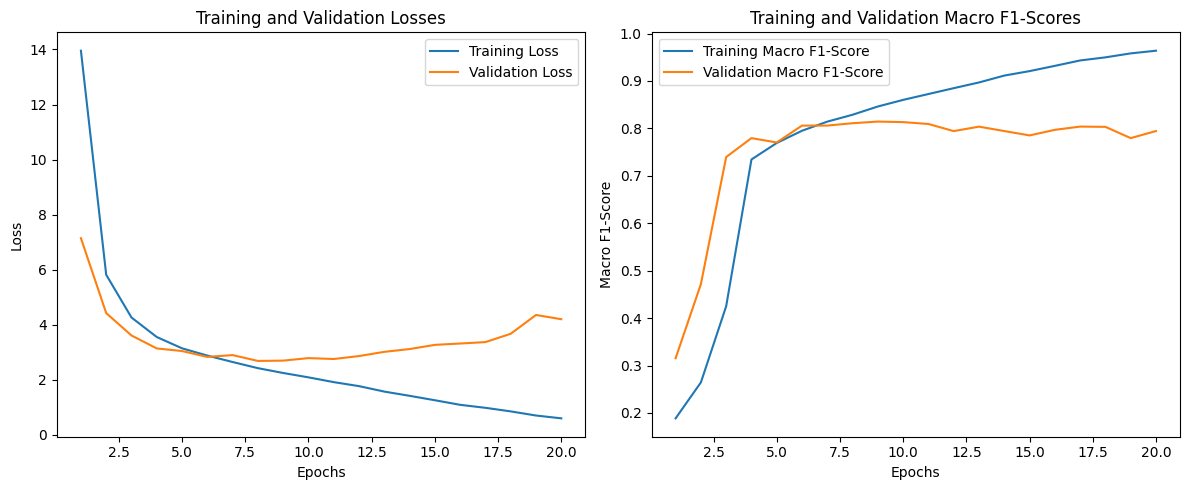

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_glove.pt
Test Loss: 4.750821492158937, Test Macro F1-Score: 0.774386641843579


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
saved_path="C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_glove.pt"

train_model(task = 2, embedding_type = "glove", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=saved_path)
test_model(task = 2, embedding_type = "glove", model = model, criterion=criterion, device=device)

Epoch 1, Training Loss: 19.51044042138618, Training Macro F1-Score: 0.06935763960903595
Epoch 1,  Validation Loss: 15.434855149568696, Validation Macro F1-Score: 0.11467878019102849
Epoch 2, Training Loss: 13.205573782672829, Training Macro F1-Score: 0.22225800868951562
Epoch 2,  Validation Loss: 12.128443492986074, Validation Macro F1-Score: 0.2700995547308254
Epoch 3, Training Loss: 11.168709149078559, Training Macro F1-Score: 0.30666906813534967
Epoch 3,  Validation Loss: 11.141788127123382, Validation Macro F1-Score: 0.32160314905876236
Epoch 4, Training Loss: 10.194723225796324, Training Macro F1-Score: 0.3404615498720662
Epoch 4,  Validation Loss: 10.663535553177889, Validation Macro F1-Score: 0.33462652834071765
Epoch 5, Training Loss: 9.537738419993472, Training Macro F1-Score: 0.3610425203067899
Epoch 5,  Validation Loss: 10.004220510465673, Validation Macro F1-Score: 0.368015677219245
Epoch 6, Training Loss: 8.989954980403029, Training Macro F1-Score: 0.40240902474320034
Epoc

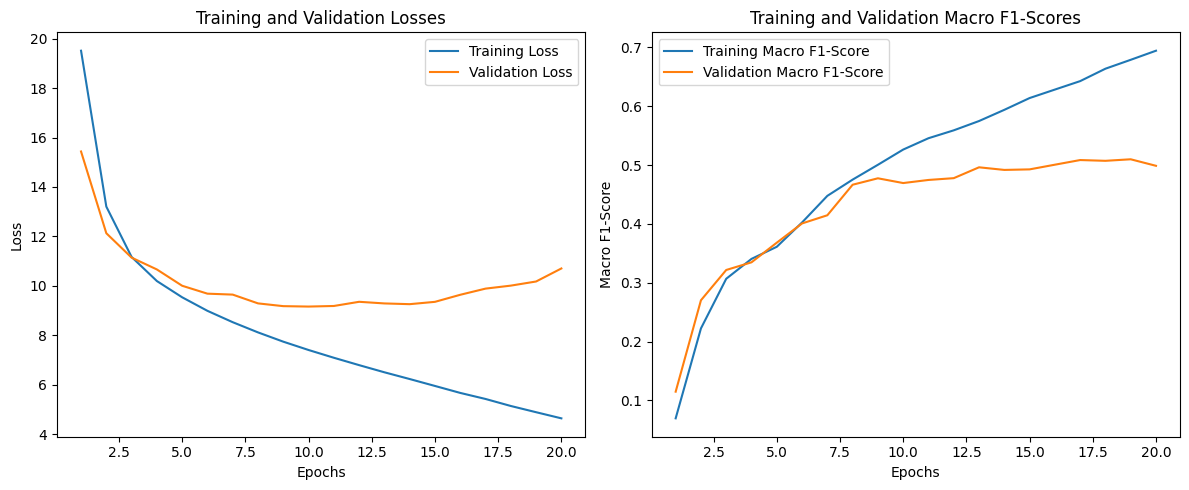

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task1_lstm_word2vec.pt
Test Loss: 11.599113182165963, Test Macro F1-Score: 0.4699109343937621


In [23]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
save_path="C:/Users/anike/Desktop/IIIT D/saved models/task1_lstm_word2vec.pt"

train_model(task = 1, embedding_type = "word2vec", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=save_path)
test_model(task = 1, embedding_type = "word2vec", model = model, criterion=criterion, device=device)

Epoch 1, Training Loss: 21.62538216715791, Training Macro F1-Score: 0.048663402774552514
Epoch 1,  Validation Loss: 18.059640804376848, Validation Macro F1-Score: 0.05624267175852594
Epoch 2, Training Loss: 16.546080613661356, Training Macro F1-Score: 0.08687297817885707
Epoch 2,  Validation Loss: 15.350192814577229, Validation Macro F1-Score: 0.11541263302981856
Epoch 3, Training Loss: 13.451973679051182, Training Macro F1-Score: 0.1937345669662804
Epoch 3,  Validation Loss: 13.191667918752403, Validation Macro F1-Score: 0.24581725717776373
Epoch 4, Training Loss: 11.695212199785939, Training Macro F1-Score: 0.2861815920347849
Epoch 4,  Validation Loss: 11.279663076524898, Validation Macro F1-Score: 0.2977035203745841
Epoch 5, Training Loss: 10.555118984923766, Training Macro F1-Score: 0.3383184024529867
Epoch 5,  Validation Loss: 10.575479600627563, Validation Macro F1-Score: 0.3265837410809802
Epoch 6, Training Loss: 9.775174846180073, Training Macro F1-Score: 0.37060942004641506
Ep

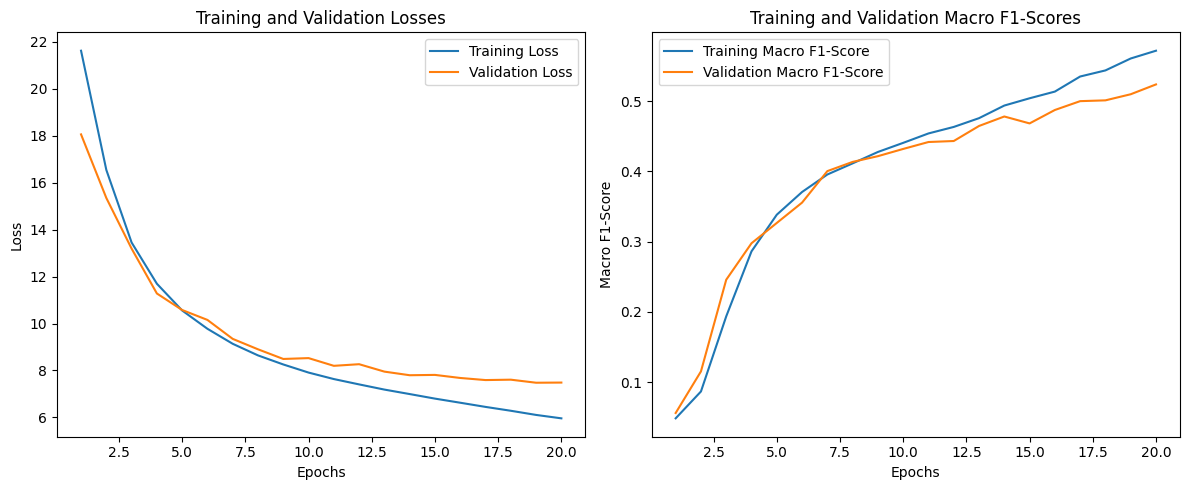

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task1_lstm_fast_text.pt
Test Loss: 8.224305212153405, Test Macro F1-Score: 0.49904867618782833


In [22]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
save_path="C:/Users/anike/Desktop/IIIT D/saved models/task1_lstm_fast_text.pt"

train_model(task = 1, embedding_type = "fast_text", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=save_path)
test_model(task = 1, embedding_type = "fast_text", model = model, criterion=criterion, device=device)

Epoch 1, Training Loss: 15.661951552953152, Training Macro F1-Score: 0.2323579501470816
Epoch 1,  Validation Loss: 8.197381334217717, Validation Macro F1-Score: 0.31532441302701336
Epoch 2, Training Loss: 7.902507463564673, Training Macro F1-Score: 0.314404896020461
Epoch 2,  Validation Loss: 6.956979478330917, Validation Macro F1-Score: 0.31532441302701336
Epoch 3, Training Loss: 6.3572707352522455, Training Macro F1-Score: 0.31755374439465256
Epoch 3,  Validation Loss: 5.268675877079027, Validation Macro F1-Score: 0.34402731827061245
Epoch 4, Training Loss: 5.150066806188482, Training Macro F1-Score: 0.39210726210280095
Epoch 4,  Validation Loss: 4.4563737269405905, Validation Macro F1-Score: 0.4349604816014743
Epoch 5, Training Loss: 4.705957448508829, Training Macro F1-Score: 0.48991635230893293
Epoch 5,  Validation Loss: 4.192905171276772, Validation Macro F1-Score: 0.5975744546707454
Epoch 6, Training Loss: 4.252752459766323, Training Macro F1-Score: 0.61648151250432
Epoch 6,  Va

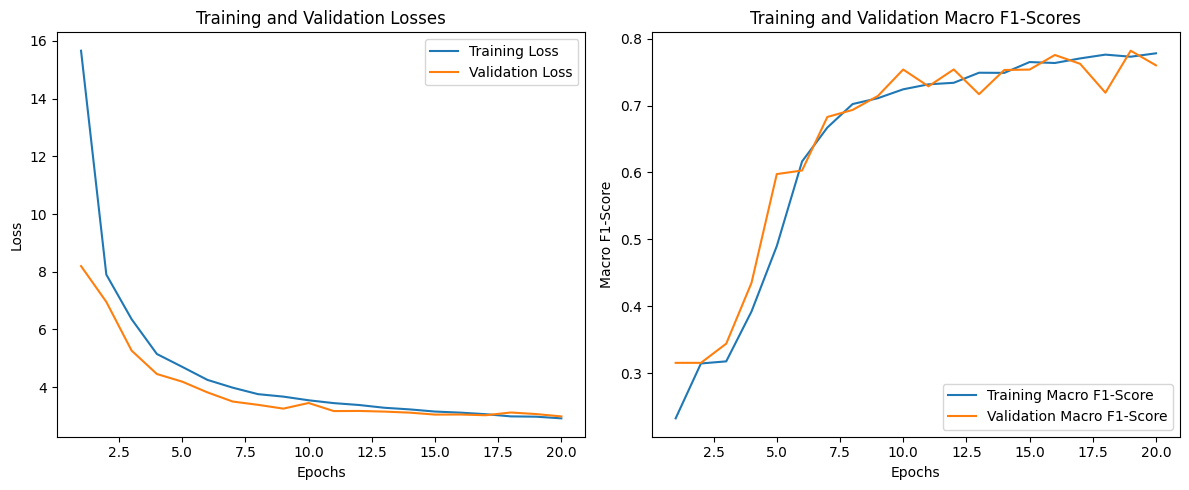

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_fast_text.pt
Test Loss: 3.245913765222834, Test Macro F1-Score: 0.7388548880395737


In [21]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
save_path="C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_fast_text.pt"

train_model(task = 2, embedding_type = "fast_text", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=save_path)
test_model(task = 2, embedding_type = "fast_text", model = model, criterion=criterion, device=device)

Epoch 1, Training Loss: 14.508346251304577, Training Macro F1-Score: 0.32656751075098883
Epoch 1,  Validation Loss: 7.896275793580704, Validation Macro F1-Score: 0.31532441302701336
Epoch 2, Training Loss: 7.5884384858950344, Training Macro F1-Score: 0.314404896020461
Epoch 2,  Validation Loss: 6.0826477590761225, Validation Macro F1-Score: 0.31532441302701336
Epoch 3, Training Loss: 5.598070110837882, Training Macro F1-Score: 0.3967321952028142
Epoch 3,  Validation Loss: 4.5540573458149005, Validation Macro F1-Score: 0.47038733625066514
Epoch 4, Training Loss: 4.66384255333452, Training Macro F1-Score: 0.488939019872596
Epoch 4,  Validation Loss: 4.080364485853884, Validation Macro F1-Score: 0.6711518257930748
Epoch 5, Training Loss: 4.122678203298556, Training Macro F1-Score: 0.6440133798309229
Epoch 5,  Validation Loss: 3.6353267560538636, Validation Macro F1-Score: 0.7441650616116883
Epoch 6, Training Loss: 3.680037806661713, Training Macro F1-Score: 0.7190763799337082
Epoch 6,  Va

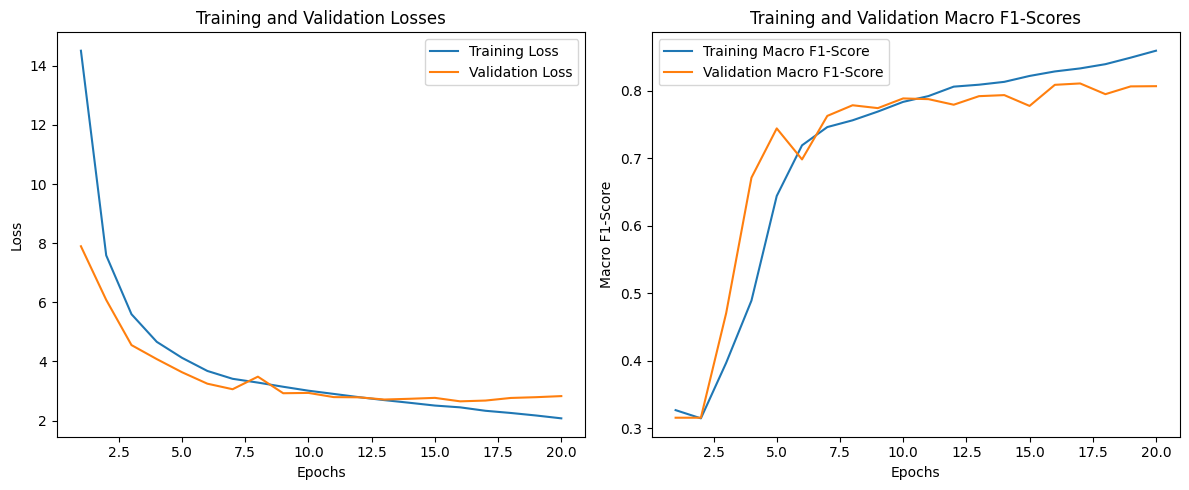

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_word2vec.pt
Test Loss: 3.4728042725416852, Test Macro F1-Score: 0.7574171957757222


In [18]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
save_path="C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_word2vec.pt"

train_model(task = 2, embedding_type = "word2vec", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=save_path)
test_model(task = 2, embedding_type = "word2vec", model = model, criterion=criterion, device=device)

Epoch 1, Training Loss: 16.93064774121063, Training Macro F1-Score: 0.1317883460200914
Epoch 1,  Validation Loss: 12.63241671862399, Validation Macro F1-Score: 0.2532771953699143
Epoch 2, Training Loss: 10.267157066755498, Training Macro F1-Score: 0.3286851708988306
Epoch 2,  Validation Loss: 9.93402557315039, Validation Macro F1-Score: 0.36219403071186007
Epoch 3, Training Loss: 8.450848328450693, Training Macro F1-Score: 0.3974027676288289
Epoch 3,  Validation Loss: 8.745871364937729, Validation Macro F1-Score: 0.4034414000846194
Epoch 4, Training Loss: 7.538714480317027, Training Macro F1-Score: 0.43462074886338903
Epoch 4,  Validation Loss: 8.275739333006921, Validation Macro F1-Score: 0.42657250496903915
Epoch 5, Training Loss: 6.868897633724081, Training Macro F1-Score: 0.4701854167274079
Epoch 5,  Validation Loss: 7.900416221733694, Validation Macro F1-Score: 0.4724389274961506
Epoch 6, Training Loss: 6.3004664915236255, Training Macro F1-Score: 0.5279785640018689
Epoch 6,  Vali

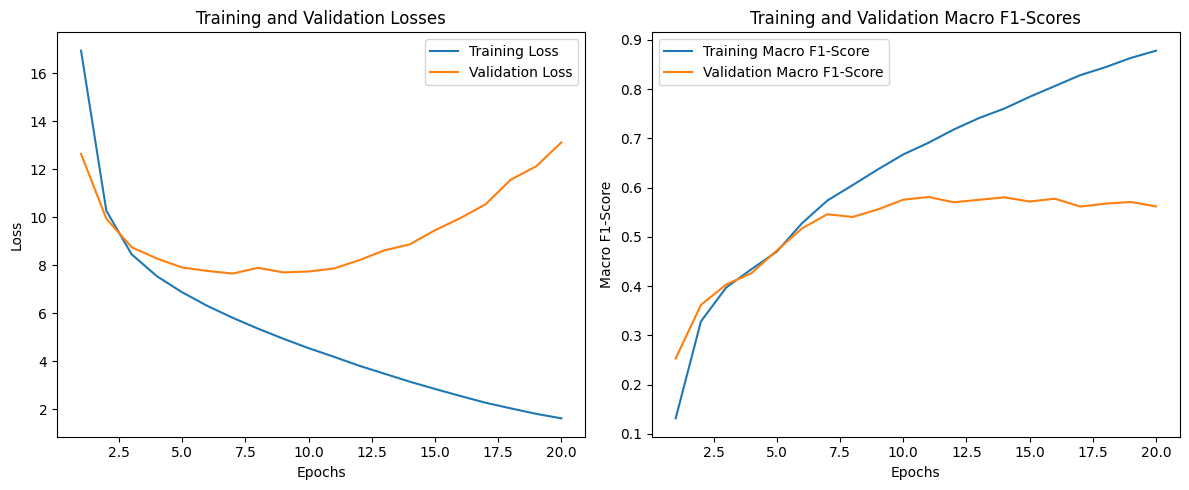

Model saved to C:/Users/anike/Desktop/IIIT D/saved models/task2_lstm_fast_text.pt
Test Loss: 14.757322178581616, Test Macro F1-Score: 0.5115595178636165


In [20]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
save_path="C:/Users/anike/Desktop/IIIT D/saved models/task1_lstm_glove.pt"

train_model(task = 1, embedding_type = "glove", model = model, optimizer=optimizer, criterion=criterion, device=device,save_path=save_path)
test_model(task = 1, embedding_type = "glove", model = model, criterion=criterion, device=device)